# Create Software Project - Take Home Midterm Exam/Assignment

* Objective: this jupyter notebook is intended to evaluate how the students understand the Duckietown repo

Prof. Nick Wang, 2016/11/7

## Instructions: 
1. $ cp assignment1.ipynb assignment1-XXXXXXX.ipynb (XXXXXXX is your name) You also need to add your name, setup, and state the contributions in the setup and contributions section.
2. You can already see the desired outputs of each cell, and you need to find the relevant code in the Duckietown repo and reproduce the results.
3. Each student needs to submit one to your mentor, via email. Please do not commit your ipynb to repo. Please do not modify assignment1.ipynb.


## Steup and Conributions:

This work is done by: 0310749.

at section Rectify the image :
   ask classmate for question aboat image size.
at section Find the edge : 
   ask classmate for question aboat gray
   
environment : Oracle VM VirtualBox.

# Line Detector

### 1.Load the image and resize

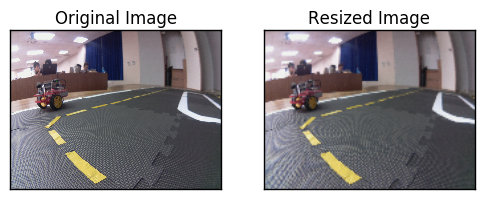

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

#Use your own image
img = cv2.imread("./images/line3.jpg")

#print img
image_cv = cv2.resize(img, (160, 120),interpolation=cv2.INTER_NEAREST)

dst1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.subplot(121),plt.imshow(dst1,cmap = 'brg')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

dst2 = cv2.cvtColor(image_cv,cv2.COLOR_BGR2RGB)
plt.subplot(122),plt.imshow(dst2,cmap = 'brg')
plt.title('Resized Image'), plt.xticks([]), plt.yticks([])

plt.show()


### 2.Find the edge (15%)

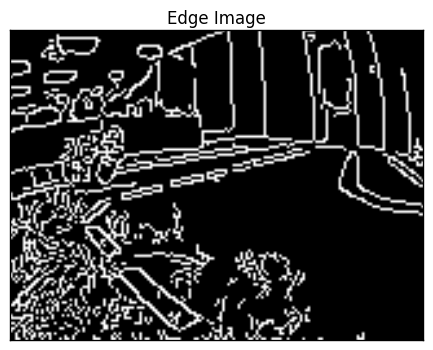

In [2]:


#You should find the config file 'universal.yaml'
#You code this
canny_thresholds = [60,150]
gray = cv2.cvtColor(image_cv, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,canny_thresholds[0],canny_thresholds[1], apertureSize=3)

plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

### 3-1.Setup HSV space threshold (15%)

In [3]:

#You should find the config file 'universal.yaml'
hsv_white1 = np.array([0,0,150])
hsv_white2 = np.array([180,100,255])
hsv_yellow1= np.array([25,50,50])
hsv_yellow2= np.array([45,255,255])
hsv_red1=    np.array([0,100,100])
hsv_red2=    np.array([15,255,255])
hsv_red3=    np.array([165,100,100])
hsv_red4=    np.array([180,255,255])
dilation_kernel_size = 3
canny_thresholds = [80,200]
sobel_threshold = 40


### 3-2.Threshold colors in HSV space (15%)

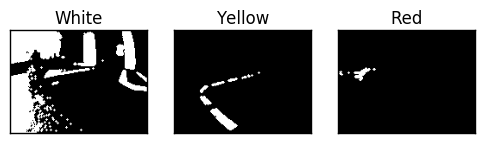

In [4]:

#change color space to HSV
hsv = cv2.cvtColor(image_cv, cv2.COLOR_BGR2HSV)

#find the color
white = cv2.inRange(hsv, hsv_white1, hsv_white2)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(dilation_kernel_size, dilation_kernel_size))
white = cv2.dilate(white, kernel)

yellow = cv2.inRange(hsv, hsv_yellow1, hsv_yellow2)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(dilation_kernel_size, dilation_kernel_size))
yellow = cv2.dilate(yellow, kernel)

red1 = cv2.inRange(hsv, hsv_red1, hsv_red2)
red2 = cv2.inRange(hsv, hsv_red3, hsv_red4)
red = cv2.bitwise_or(red1, red2)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(dilation_kernel_size, dilation_kernel_size))
red = cv2.dilate(red, kernel)

# Uncomment '#' to plot with color
x = cv2.cvtColor(yellow, cv2.COLOR_GRAY2BGR)
x[:,:,2] *= 1
x[:,:,1] *= 1
x[:,:,0] *= 0
x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)

y = cv2.cvtColor(red, cv2.COLOR_GRAY2BGR)
y[:,:,2] *= 1
y[:,:,1] *= 0
y[:,:,0] *= 0
y = cv2.cvtColor(y, cv2.COLOR_BGR2RGB)

plt.subplot(131),plt.imshow(white,cmap = 'gray')
plt.title('White'), plt.xticks([]), plt.yticks([])

plt.subplot(132),plt.imshow(yellow,cmap = 'gray')
#plt.subplot(132),plt.imshow(x,cmap = 'brg')
plt.title('Yellow'), plt.xticks([]), plt.yticks([])

plt.subplot(133),plt.imshow(red,cmap = 'gray')
#plt.subplot(133),plt.imshow(y,cmap = 'brg')
plt.title('Red'), plt.xticks([]), plt.yticks([])

plt.show()

### 4.Combine Edge and Colors (15%)

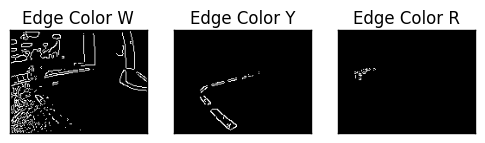

In [5]:

edge_color_white = cv2.bitwise_and(white, edges)
edge_color_yellow = cv2.bitwise_and(yellow, edges)
edge_color_red = cv2.bitwise_and(red, edges)


plt.imshow(edge_color_yellow,cmap = 'gray')
plt.title('Edge Color Y'), plt.xticks([]), plt.yticks([])
plt.subplot(131),plt.imshow(edge_color_white,cmap = 'gray')
plt.title('Edge Color W'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(edge_color_yellow,cmap = 'gray')
plt.title('Edge Color Y'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(edge_color_red,cmap = 'gray')
plt.title('Edge Color R'), plt.xticks([]), plt.yticks([])

plt.show()

### 5-1.Find the lines (15%)

In [6]:

#default threshold 20-> 10
def _lineFilter(bw, edge_color):
        # find gradient of the bw image
        grad_x = -cv2.Sobel(bw/255, cv2.CV_32F, 1, 0, ksize=5)
        grad_y = -cv2.Sobel(bw/255, cv2.CV_32F, 0, 1, ksize=5)
        grad_x *= (edge_color == 255)
        grad_y *= (edge_color == 255)

        # compute gradient and thresholding
        grad = np.sqrt(grad_x**2 + grad_y**2)
        roi = (grad>sobel_threshold)

        #print np.unique(grad)
        #print np.sum(roi)

        # turn into a list of points and normals
        roi_y, roi_x = np.nonzero(roi)
        centers = np.vstack((roi_x, roi_y)).transpose()
        normals = np.vstack((grad_x[roi], grad_y[roi])).transpose()
        normals /= np.sqrt(np.sum(normals**2, axis=1, keepdims=True))

        lines = _synthesizeLines(centers, normals)

        return lines, normals, centers
def _synthesizeLines(centers, normals):
        lines = []
        if len(centers)>0:
            x1 = (centers[:,0:1] + normals[:, 1:2] * 6.).astype('int')
            y1 = (centers[:,1:2] - normals[:, 0:1] * 6.).astype('int')
            x2 = (centers[:,0:1] - normals[:, 1:2] * 6.).astype('int')
            y2 = (centers[:,1:2] + normals[:, 0:1] * 6.).astype('int')
            x1 = _checkBounds(x1, img.shape[1])
            y1 = _checkBounds(y1, img.shape[0])
            x2 = _checkBounds(x2, img.shape[1])
            y2 = _checkBounds(y2, img.shape[0])
            lines = np.hstack([x1, y1, x2, y2])
        return lines
def _checkBounds(val, bound):
        val[val<0]=0
        val[val>=bound]=bound-1
        return val
#use linefilter
lines_white = _lineFilter(white,white)
lines_yellow = _lineFilter(yellow,yellow)
lines_red = _lineFilter(red,red)
#end use linefilter
hough_threshold = 20
hough_min_line_length =  3
hough_max_line_gap =  1
#use HoughLines
lines_white = cv2.HoughLinesP(white, 1, np.pi/180, hough_threshold, np.empty(1),hough_min_line_length, hough_max_line_gap)
lines_yellow = cv2.HoughLinesP(yellow, 1, np.pi/180, hough_threshold, np.empty(1),hough_min_line_length, hough_max_line_gap)
lines_red = cv2.HoughLinesP(red, 1, np.pi/180, hough_threshold, np.empty(1),hough_min_line_length, hough_max_line_gap)
#end HoughLines
color = "yellow"
lines = lines_yellow
bw = yellow

if lines is not None:
    lines = np.array(lines[0])
    print "found lines"

else:
    lines = []
    print "no lines"


found lines


### Show the lines (yellow)

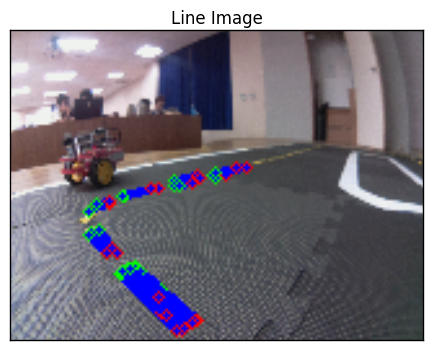

In [7]:
image_with_lines = np.copy(image_cv)
image_with_lines = cv2.cvtColor(image_with_lines,cv2.COLOR_BGR2RGB)
if len(lines)>0:
    for x1,y1,x2,y2 in lines:
        cv2.line(image_with_lines, (x1,y1), (x2,y2), (0,0,255), 2)
        cv2.circle(image_with_lines, (x1,y1), 2, (0,255,0))
        cv2.circle(image_with_lines, (x2,y2), 2, (255,0,0))
        
plt.imshow(image_with_lines,cmap = 'brg')
plt.title('Line Image'), plt.xticks([]), plt.yticks([])
plt.show()

### 6-1.Normals (15%)

In [8]:
arr_cutoff = np.array((0, 40, 0, 40))
arr_ratio = np.array((1./160, 1./120, 1./160, 1./120))
        
normals = []
centers = []
if len(lines)>0:
    
    #find the normalized coordinates
    lines_normalized = ((lines + arr_cutoff) * arr_ratio)

    #find the dx dy
    length = np.sum((lines[:, 0:2] -lines[:, 2:4])**2, axis=1, keepdims=True)**0.5
    dx = 1.* (lines[:,3:4]-lines[:,1:2])/length
    dy = 1.* (lines[:,0:1]-lines[:,2:3])/length

    #find the center point
    centers = np.hstack([(lines[:,0:1]+lines[:,2:3])/2, (lines[:,1:2]+lines[:,3:4])/2])

    #find the vectors' direction
    x3 = (centers[:,0:1] - 3.*dx).astype('int')
    x3[x3<0]=0
    x3[x3>=160]=160-1

    y3 = (centers[:,1:2] - 3.*dy).astype('int')
    y3[y3<0]=0
    y3[y3>=120]=120-1

    x4 = (centers[:,0:1] + 3.*dx).astype('int')
    x4[x4<0]=0
    x4[x4>=160]=160-1

    y4 = (centers[:,1:2] + 3.*dy).astype('int')
    y4[y4<0]=0
    y4[y4>=120]=120-1
    
   
    #find the dx dy direction
    flag_signs = (np.logical_and(bw[y3,x3]>0, bw[y4,x4]==0)).astype('int')*2-1

    normals = np.hstack([dx, dy]) * flag_signs

    
    flag = ((lines[:,2]-lines[:,0])*normals[:,1] - (lines[:,3]-lines[:,1])*normals[:,0])>0
    for i in range(len(lines)):
        if flag[i]:
            x1,y1,x2,y2 = lines[i, :]
            lines[i, :] = [x2,y2,x1,y1]

### 6-2.Draw the Normals 

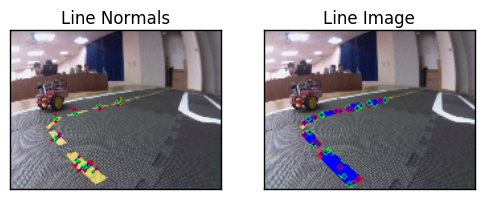

In [9]:
image_with_lines = np.copy(image_cv)
image_with_lines = cv2.cvtColor(image_cv,cv2.COLOR_BGR2RGB)
if len(centers)>0:
    for x,y,dx,dy in np.hstack((centers,normals)):
        x3 = int(x - 2.*dx)
        y3 = int(y - 2.*dy)
        x4 = int(x + 2.*dx)
        y4 = int(y + 2.*dy)
        cv2.line(image_with_lines, (x3,y3), (x4,y4), (0,0,255), 1)
        cv2.circle(image_with_lines, (x3,y3), 1, (0,255,0))
        cv2.circle(image_with_lines, (x4,y4), 1, (255,0,0))
            
plt.subplot(121),plt.imshow(image_with_lines,cmap = 'brg')
plt.title('Line Normals'), plt.xticks([]), plt.yticks([])

image_with_lines = np.copy(dst2)
if len(lines)>0:
    for x1,y1,x2,y2 in lines:
        cv2.line(image_with_lines, (x1,y1), (x2,y2), (0,0,255), 2)
        cv2.circle(image_with_lines, (x1,y1), 2, (0,255,0))
        cv2.circle(image_with_lines, (x2,y2), 2, (255,0,0))
        
plt.subplot(122),plt.imshow(image_with_lines,cmap = 'brg')
plt.title('Line Image'), plt.xticks([]), plt.yticks([])
plt.show()

### 7-1.setup the segment class

In [10]:
class Vector2D():
    def __init__(self):
        self.x = 0
        self.y = 0  
class Segment():
    def __init__(self):
        self.color = ""
        self.pixels_normalized = np.array([Vector2D(),Vector2D()])
        self.normal = Vector2D()
        

### 7-2.Store in the SegmentList 

In [95]:
segmentMsgList = []

for x1,y1,x2,y2,norm_x,norm_y in np.hstack((lines_normalized,normals)):
    segment = Segment()
    segment.color = color
    segment.pixels_normalized[0].x = x1
    segment.pixels_normalized[0].y = y1
    segment.pixels_normalized[1].x = x2
    segment.pixels_normalized[1].y = y2
    segment.normal.x = norm_x
    segment.normal.y = norm_y

    segmentMsgList.append(segment)  
    
print segmentMsgList[2].pixels_normalized[1].x

0.4125


### 7.3 Print the SegmentList

In [96]:
for i in segmentMsgList:
    print (i.pixels_normalized[0].x,i.pixels_normalized[0].y),(i.pixels_normalized[1].x,i.pixels_normalized[1].y)

(0.29375000000000001, 1.1000000000000001) (0.42500000000000004, 1.2833333333333332)
(0.48750000000000004, 0.80000000000000004) (0.56874999999999998, 0.77500000000000002)
(0.28125, 1.1000000000000001) (0.41250000000000003, 1.3)
(0.39375000000000004, 0.81666666666666665) (0.45000000000000001, 0.80000000000000004)
(0.30625000000000002, 1.1333333333333333) (0.41875000000000001, 1.2916666666666667)
(0.26250000000000001, 1.1166666666666667) (0.40000000000000002, 1.3)
(0.30000000000000004, 1.0916666666666666) (0.45000000000000001, 1.2666666666666666)
(0.19375000000000001, 0.98333333333333328) (0.25625000000000003, 1.05)
(0.30000000000000004, 1.1000000000000001) (0.43125000000000002, 1.2749999999999999)
(0.49375000000000002, 0.80833333333333335) (0.51875000000000004, 0.80000000000000004)
(0.26874999999999999, 1.1166666666666667) (0.36250000000000004, 1.2416666666666667)
(0.36250000000000004, 1.1666666666666667) (0.44375000000000003, 1.2666666666666666)
(0.39375000000000004, 0.83333333333333337

# Ground Projection 

In [97]:
lines_normalized, normals


print lines_normalized[0,1],normals[0]


1.1 [-0.72335554  0.69047575]


### camera parameters


In [98]:
import cv2
import numpy as np
#camera_matrix = np.array([[1.3e+03, 0., 6.0e+02], [0., 1.3e+03, 4.8e+02], [0., 0., 1.]], dtype=np.float32)
#dist_coeffs = np.array([-2.4-01, 9.5e-02, -4.0e-04, 8.9e-05, 0.], dtype=np.float32)

#Use your own homography & intrinsic camera_matrix and dist_coeffs
homography = np.array([[4.7735e-05, -0.0002136365, -0.2214576 ],
                       [0.001002189, -3.369404e-05, -0.3031031],
                       [-4.332491e-05, -0.006859886, 1        ]])

matrix = np.array([[397.2313423887745, 0.0, 321.36163202144127],
                  [0.0, 398.5399144224602, 246.47954600504573],
                 [0.0, 0.0, 1.0                             ]])
coeffs = np.array([-0.3929879882933439, 0.11340416624167338, 
                   -0.006579341864704046, -7.794987161672481e-06,
                    0.0])

#matrix = np.array([[316.52597444317314, 0.0, 320.9948809392584], [0.0, 321.2731572848207, 205.92052874401818],
#    [0.0, 0.0, 1.0]])
#coeffs = np.array([-0.2601671987836283, 0.04662981063335094, 0.005020360395041378, 0.0029019828987683857,
#    0.0])

In [99]:
pt_img = np.array([[0.5*640],[0.7*480],[1.]])
#print pt_img
G = np.dot(homography,pt_img)
G/=G[2]
print G

pt_img = np.array([[[0.5*640,0.7*480]]])

xy_undistorted = cv2.undistortPoints(pt_img, matrix, coeffs,R=None, P=matrix)
pt_img = np.array([[xy_undistorted[0][0][0]],[xy_undistorted[0][0][1]],[1.]])
#print xy_undistorted
G_rect = np.dot(homography,pt_img)
G_rect/=G_rect[2]
print matrix
print G_rect

[[ 0.21077289]
 [-0.00475906]
 [ 1.        ]]
[[ 397.23134239    0.          321.36163202]
 [   0.          398.53991442  246.47954601]
 [   0.            0.            1.        ]]
[[ 0.20864665]
 [-0.00461996]
 [ 1.        ]]


### Rectify the image (15%) 

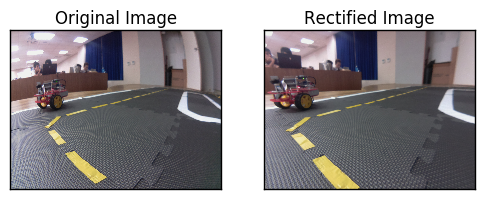

In [100]:
from matplotlib import pyplot as plt
#Use your own image
origin = cv2.imread("images/line3.jpg")
img = cv2.resize(origin, (640, 480),interpolation=cv2.INTER_NEAREST)

#rectfy the image by opencv 'undistort'
rec_img = cv2.undistort(img, matrix , coeffs,matrix);


origin = cv2.cvtColor(origin,cv2.COLOR_BGR2RGB)
plt.subplot(121),plt.imshow(origin,cmap = 'brg')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

rec_img = cv2.cvtColor(rec_img,cv2.COLOR_BGR2RGB)
plt.subplot(122),plt.imshow(rec_img,cmap = 'brg')
plt.title('Rectified Image'), plt.xticks([]), plt.yticks([])

plt.show()

# Duckietown Lane Filter

up/down arrow keys to move, enter to edit

Esc to exit edit mode

Shift + enter to run code

1/2/3... to add comment

dd to delete cell

press h for more shortcuts

In [114]:
import numpy as np
from scipy.stats import multivariate_normal, entropy
from scipy.ndimage.filters import gaussian_filter
from math import floor, atan2, pi, cos, sin, sqrt
import time
from matplotlib import pyplot as plt

## Environment Setup

In [115]:
# constant
WHITE = 0
YELLOW = 1
RED = 2

lanewidth = 0.4
linewidth_white = 0.04
linewidth_yellow = 0.02
pi = 3.14159


## Generate Vote (Extra Credit 10% for generating multiple votes from all detected segments)

#### Setup a line segment
* left edge of white lane
* right edge of white lane
* left edge of yellow lane
* right edge of white lane

[0.29375000000000001, 1.1000000000000001]
[0.42500000000000004, 1.2833333333333332]
[1, 1, 1]
[0.48750000000000004, 0.80000000000000004]
[0.56874999999999998, 0.77500000000000002]
[1, 1, 1]
[0.28125, 1.1000000000000001]
[0.41250000000000003, 1.3]
[1, 1, 1]
[0.39375000000000004, 0.81666666666666665]
[0.45000000000000001, 0.80000000000000004]
[1, 1, 1]
[0.30625000000000002, 1.1333333333333333]
[0.41875000000000001, 1.2916666666666667]
[1, 1, 1]
[0.26250000000000001, 1.1166666666666667]
[0.40000000000000002, 1.3]
[1, 1, 1]
[0.30000000000000004, 1.0916666666666666]
[0.45000000000000001, 1.2666666666666666]
[1, 1, 1]
[0.19375000000000001, 0.98333333333333328]
[0.25625000000000003, 1.05]
[1, 1, 1]
[0.30000000000000004, 1.1000000000000001]
[0.43125000000000002, 1.2749999999999999]
[1, 1, 1]
[0.49375000000000002, 0.80833333333333335]
[0.51875000000000004, 0.80000000000000004]
[1, 1, 1]
[0.26874999999999999, 1.1166666666666667]
[0.36250000000000004, 1.2416666666666667]
[1, 1, 1]
[0.362500000000

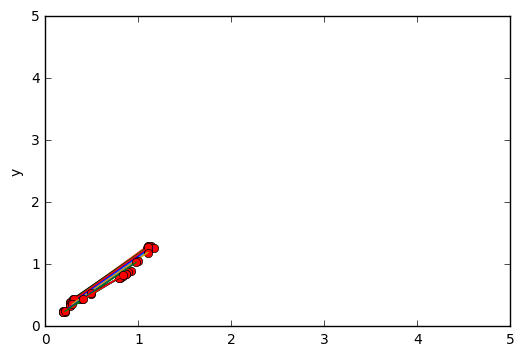

In [122]:

# right edge of white lane
#p1 = np.array([0.8, 0.24])
#p2 = np.array([0.4, 0.24])
pList = [] 
for a in segmentMsgList:
    if a.color == "white" :
        p = np.array([[a.pixels_normalized[0].x/a.normal.x,a.pixels_normalized[0].y/a.normal.y],
                      [a.pixels_normalized[1].x/a.normal.x,a.pixels_normalized[1].y/a.normal.y],
                      [0,0,0]])
    else:
        p = np.array([[a.pixels_normalized[0].x,a.pixels_normalized[0].y],
                      [a.pixels_normalized[1].x,a.pixels_normalized[1].y],
                      [1,1,1]])
    pList.append(p)
    #print p1
    #print p2
    plt.plot([p[0][0], p[0][1]], [p[1][0], p[1][1]], 'ro')
    plt.plot([p[0][0], p[0][1]], [p[1][0], p[1][1]])
for a in pList:
    print a[0]
    print a[1]
    print a[2]
#p1 = np.array([lines_normalized[0][0],lines_normalized[0][1]])
#p2 = np.array([lines_normalized[0][2],lines_normalized[0][3]]) 
#seg_color = YELLOW
#print p1
#print p2

# left edge of white lane
#p1 = np.array([0.4, 0.2])
#p2 = np.array([0.8, 0.2])
#seg_color = WHITE


plt.ylabel('y')
plt.axis([0, 5, 0, 5])
plt.show()


#### compute d_i, phi_i, l_i

In [124]:

dplList = []
for p in pList:
    p1 = np.array(p[0]);
    p2 = np.array(p[1]);
    t_hat = (p1-p2)/np.linalg.norm(p1-p2)
    n_hat = np.array([-t_hat[1],t_hat[0]])
    print (t_hat,n_hat)
    d = np.array([np.inner(n_hat,p1),
                  np.inner(n_hat,p2)])
    l = np.array([np.inner(t_hat,p1),
                  np.inner(t_hat,p2)])
    print (d[0], d[1], l[0], l[1])
    if (l[0] < 0):
        l[0] = -l[0];
    if (l[1] < 0):
        l[1] = -l[1];
    l_i = (l[0]+l[1])/2
    d_i = (d[0]+d[1])/2
    print d_i
    phi_i = np.arcsin(t_hat[1])
    if p[2][0] == 0: # right lane is white
        if(p1[0] > p2[0]): # right edge of white lane
            d_i = d_i - linewidth_white
            print ('right edge of white lane')
        else: # left edge of white lane
            d_i = - d_i
            phi_i = -phi_i
            print ('left edge of white lane')
        d_i = d_i - lanewidth/2
    elif p[2][0] == 1: # left lane is yellow
        if (p2[0] < p1[0]): # left edge of yellow lane
            d_i = d_i - linewidth_yellow
            phi_i = -phi_i
            print ('left edge of yellow lane')
        else: # right edge of white lane
            d_i = -d_i
            print ('right edge of yellow lane')
        d_i =  lanewidth/2 - d_i
    temp = np.array([[p1[0],p1[1],0],
                     [p2[0],p2[1],0],
                     [d_i,phi_i,l_i]])
    dplList.append(temp)
    
#l_iList = []
#d_iList = []
#for l in lList
#    if (l[0] < 0):
#        l[0] = -l[0];
#    if (l[1] < 0):
#        l[1] = -l[1];
#    l_i = (l[0]+l[1])/2
#    d_i = (d[0]+d[1])/2
#    dList.append(d_i)
#    lList.append(l_i)
#    phi_i = np.arcsin(t_hat[1])
#if seg_color == WHITE: # right lane is white
#    if(p1[0] > p2[0]): # right edge of white lane
#        d_i = d_i - linewidth_white
#        print ('right edge of white lane')
#    else: # left edge of white lane
#       d_i = - d_i
#        phi_i = -phi_i
#        print ('left edge of white lane')
#    d_i = d_i - lanewidth/2

#elif seg_color == YELLOW: # left lane is yellow
#    if (p2[0] > p1[0]): # left edge of yellow lane
#        d_i = d_i - linewidth_yellow
#        phi_i = -phi_i
#        print ('right edge of yellow lane')
#    else: # right edge of white lane
#        d_i = -d_i
#        print ('right edge of yellow lane')
#    d_i =  lanewidth/2 - d_i

for dpl in dplList   : 
    print (dpl[2][0], dpl[2][1], dpl[2][2]) 

(array([-0.5821119 , -0.81310869]), array([ 0.81310869, -0.5821119 ]))
(-0.40147241379111037, -0.40147241379111037, -1.0654149254936969, -1.2908870382063582)
-0.401472413791
right edge of yellow lane
(array([-0.95577901,  0.29408585]), array([-0.29408585, -0.95577901]))
(-0.90799005828585277, -0.90799005828585277, -0.23067358768193177, -0.31568277836152825)
-0.907990058286
right edge of yellow lane
(array([-0.54865644, -0.83604791]), array([ 0.83604791, -0.54865644]))
(-0.36838361071258108, -0.36838361071258102, -1.0739623260889377, -1.3131830662014958)
-0.368383610713
right edge of yellow lane
(array([-0.95879811,  0.28408833]), array([-0.28408833, -0.95879811]))
(-0.89487823852782789, -0.894878238527828, -0.14552128763097283, -0.20418848696567576)
-0.894878238528
right edge of yellow lane
(array([-0.57920713, -0.81518041]), array([ 0.81518041, -0.57920713]))
(-0.40678574978287374, -0.40678574978287374, -1.1012533136013847, -1.2954843472814956)
-0.406785749783
right edge of yellow lan

### Measurement Likelihood

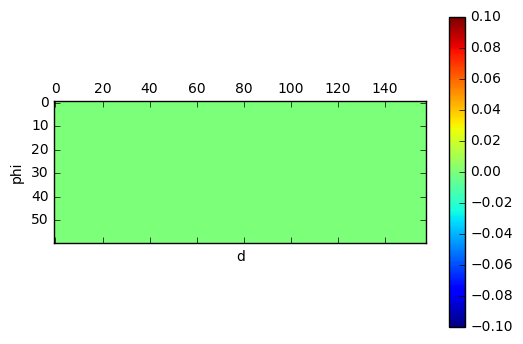

In [125]:
# initialize measurement likelihood

d_min = -0.7
d_max = 0.5
delta_d = 0.02
phi_min = -pi/2
phi_max = pi/2
delta_phi = 0.02
d, phi = np.mgrid[d_min:d_max:delta_d, phi_min:phi_max:delta_phi]

measurement_likelihood = np.zeros(d.shape)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(measurement_likelihood, interpolation='nearest')
fig.colorbar(cax)
plt.ylabel('phi')
plt.xlabel('d')
#ax.set_xticklabels(['']+alpha)
#ax.set_yticklabels(['']+alpha)
plt.show()



/home/robotvision/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(24.0, 31.0)
(-1.0, 93.0)
(26.0, 29.0)
(0.0, 92.0)
(24.0, 30.0)
(22.0, 32.0)
(20.0, 35.0)
(18.0, 37.0)
(23.0, 32.0)
(-2.0, 94.0)
(22.0, 32.0)
(22.0, 34.0)
(-1.0, 97.0)
(-1.0, 101.0)
(22.0, 32.0)
(-1.0, 91.0)
(24.0, 32.0)
(-1.0, 93.0)
(-1.0, 95.0)
(23.0, 32.0)
(-1.0, 94.0)
(22.0, 32.0)
(31.0, 24.0)
(-1.0, 91.0)


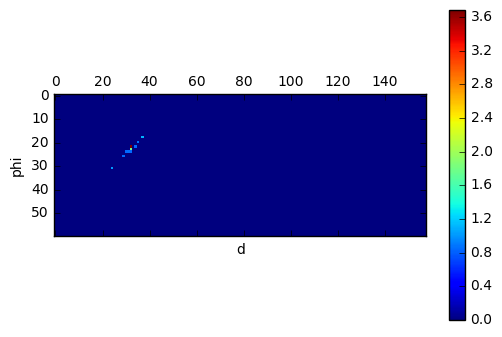

In [126]:
for dpl in dplList:
    i = floor((dpl[2][0] - d_min)/delta_d)
    j = floor((dpl[2][1] - phi_min)/delta_phi)
    if (i < 60 and j < 60) : 
        measurement_likelihood[i,j] = measurement_likelihood[i,j] +  1/(dpl[2][2])
    print (i, j)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(measurement_likelihood, interpolation='nearest')
fig.colorbar(cax)
plt.ylabel('phi')
plt.xlabel('d')
#ax.set_xticklabels(['']+alpha)
#ax.set_yticklabels(['']+alpha)
plt.show()

## Bayes' Filter (Extra Credit 10% for integrating Bayes' filter for multiple votes)